In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklean imports 
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import *

In [2]:
# Set colour palette 

greys = ['#767676', '#b3b3b3', '#212121']
sns.set_palette(sns.color_palette(greys))


# Data import and cleaning 

In [3]:
# Data import
df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))
df_raw.drop(axis=0, labels=range(25292,len(df_raw)), inplace=True)

#--------------------------------------------------------------------------------------------------
# Data cleaning 
df = df_raw.copy()
df = df.apply(pd.to_numeric)
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

tmp = df.columns
tmp = list(tmp)

#--------------------------------------------------------------------------------------------------
# Column headers have random spaces, so i removed them 
out = []
for i in tmp:
    out.append(i.replace(' ', ''))

df.columns = out

# Changing date to actual date format 
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: (x[:4] + '-' + x[4:6] + '-' + x[6:]))
df['Date'] = pd.to_datetime(df['Date'])

df.head()
#df.info()

C:\Users\seanl\AppData\Local\Temp\ipykernel_3348\1305765991.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))


,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,-99.99,-1.39,0.00,-1.44,0.62,-1.27,-0.90,...,-0.93,0.14,2.77,-0.02,0.27,0.59,0.47,0.81,0.57,-1.66
1,1926-07-02,0.29,0.06,-99.99,0.78,0.70,1.46,0.03,0.00,-0.34,...,1.07,0.07,0.00,0.01,-0.10,1.04,-0.03,-0.61,-1.03,3.09
2,1926-07-06,-0.33,0.18,-99.99,-1.74,0.50,-0.96,-0.06,4.27,-1.20,...,0.73,-0.20,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.62,1.41
3,1926-07-07,3.57,-0.15,-99.99,-1.73,-0.12,-0.49,-0.06,-4.10,-0.22,...,2.22,0.18,-3.21,-0.57,-1.08,-1.09,0.21,0.07,0.17,0.62
4,1926-07-08,0.30,1.12,-99.99,-0.15,0.30,-0.49,0.24,0.00,-0.01,...,-0.39,0.46,-1.10,-0.38,0.33,0.99,-0.88,-0.36,-1.10,0.98


# Min-Var Portfolio

In [4]:
# Selecting only the most recent 63 days 
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

temp = df.copy()
temp = temp.iloc[date_i-no_obj:date_i,:]
temp.shape

# FOR TESTING 
temp = temp[['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys']]

# Use the first 63 as training data
R_train = temp
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

arr_len = 6

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train = np.dot(R_train, N)

In [5]:
# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w = eq_w - np.dot(N,beta)

#--------------------------------------------------------------------------------------------------

print(f'train_r2: {train_r2}')
print(f'train_mse: {train_mse}')
print('\n')

print(f'beta: {beta}')
print(f'w            : {[round(num, 3) for num in w]}')
print(f'Actual values: {str([-.002, -.004, .049, .514, .316, .128])}')

train_r2: 0.22247593212981887
train_mse: 0.46020583341227367


beta: [ 0.16927953  0.16834143  0.11724264 -0.34557298 -0.14832212]
w            : [-0.003, -0.002, 0.049, 0.512, 0.315, 0.128]
Actual values: [-0.002, -0.004, 0.049, 0.514, 0.316, 0.128]


# Calculating returns 

In [6]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
test = ['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys']

eq_w = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]
w_min_var = [-0.002, -0.004, 0.049, 0.514, 0.316, 0.128]
w_lasso = [1.56, 0.459, -0.099, 1.088, -1.741, -0.267]
w_ridge = [0.179, 0.531, 0.173, 0.348, -0.235, 0.004]
test_portfolio = [eq_w, w_min_var, w_lasso, w_ridge]



def returns_calc(df, industries, final_date, days_range, portfolio_lst):
    # Vectorise, and add a new column for the return
    q4_df = df.copy()
    q4_df = q4_df[industries]

    date = str(final_date)
    no_obj = days_range

    date_i = df[df['Date'] == date].index[0]

    q4_df = q4_df.copy()
    q4_df = q4_df.iloc[date_i-no_obj:date_i,:]

    #--------------------------------------------------------------------------------------------------
    # Dates 
    date_index = df.copy()
    date_index = date_index['Date']

    date_i = df[df['Date'] == date].index[0]

    date_index = date_index.copy()
    date_index = date_index.iloc[date_i-no_obj:date_i]

    #--------------------------------------------------------------------------------------------------
    portfolios_str = ['eq_w', 'w_min_var', 'w_lasso', 'w_ridge']

    returns = pd.DataFrame()
    counter = 0

    for weight in portfolio_lst:
        returns[str(portfolios_str[counter])+' return'] = q4_df.mul(weight, axis = 1).sum(axis = 1)
        counter += 1


    returns.set_index(date_index, inplace = True)
    returns = returns.reset_index()
    return(returns)


returns_calc(df, test, '2022-01-04', 63, test_portfolio ).iloc[-1:,2]

62    0.20767
Name: w_min_var return, dtype: float64

In [7]:
def cumulative_returns_calc(df, industries, final_date, days_range, portfolio_lst):
    returns = returns_calc(df, industries, final_date, days_range, portfolio_lst)
    
    out = returns.iloc[:,1:].cumsum()
    out.set_index(returns.iloc[:,0],inplace = True)
    out = out.reset_index()
    return(out)

cumulative_returns_calc(df, test, '2022-01-04', 63, test_portfolio)

,Date,eq_w return,w_min_var return,w_lasso return,w_ridge return
0,2021-10-05,0.74649,0.29909,3.60568,0.98848
1,2021-10-06,1.27755,1.64494,0.38179,1.74566
2,2021-10-07,1.91716,2.27922,3.66094,2.48902
3,2021-10-08,1.75684,2.14633,4.44731,2.32799
4,2021-10-11,1.38944,1.95439,3.92637,2.21990
...,...,...,...,...,...
58,2021-12-28,4.57747,5.67623,36.03024,11.85782
59,2021-12-29,4.61087,5.88421,35.73823,12.04188
60,2021-12-30,4.93652,6.15345,34.47684,11.91203
61,2021-12-31,5.25716,6.52907,35.11936,12.52034


# Calculating Optimum values of alpha

A low alpha value can lead to over-fitting, whereas a high alpha value can lead to under-fitting.

In [8]:
# Creating the dataset for cross validation 
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

industry_lst = [ind_6, ind_24, ind_48]

#--------------------------------------------------------------------------------------------------

for i in industry_lst:
    temp = df.copy()
    temp = temp[i]

    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]
    R_train = temp.iloc[date_i-63:date_i,:]

    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(no_obj / .7 * .3)
    date_i = df[df['Date'] == date].index[0]
    R_test = temp.iloc[date_i:date_i+no_obj,:]

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)

    #-------------------------------------------------------------------------------------------
    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_r.fit(X_train_raw, y_train_raw)
    
    print(f'{len(i)} industry: {grid_r.best_params_}')
    
    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("lasso", Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_l.fit(X_train_raw, y_train_raw)
    
    print(f'{len(i)} industry: {grid_l.best_params_}')
    print('\n')
    

6 industry: {'ridge__alpha': 151.99110829529394}
6 industry: {'lasso__alpha': 0.39442060594376643}


24 industry: {'ridge__alpha': 34.30469286314926}
24 industry: {'lasso__alpha': 0.08902150854450393}


48 industry: {'ridge__alpha': 104.76157527896662}
48 industry: {'lasso__alpha': 0.12915496650148853}




In [9]:
# ALPHA VARIABLES
ridge_6_alpha = 151.99110829529394
ridge_24_alpha = 34.30469286314926
ridge_48_alpha = 104.76157527896662

lasso_6_alpha = 0.39442060594376643
lasso_24_alpha = 0.08902150854450393
lasso_48_alpha = 0.12915496650148853

### This is just a visualistion of how we got our alphas

6 industry: {'ridge__alpha': 151.99110829529394}
6 industry: {'lasso__alpha': 0.39442060594376643}




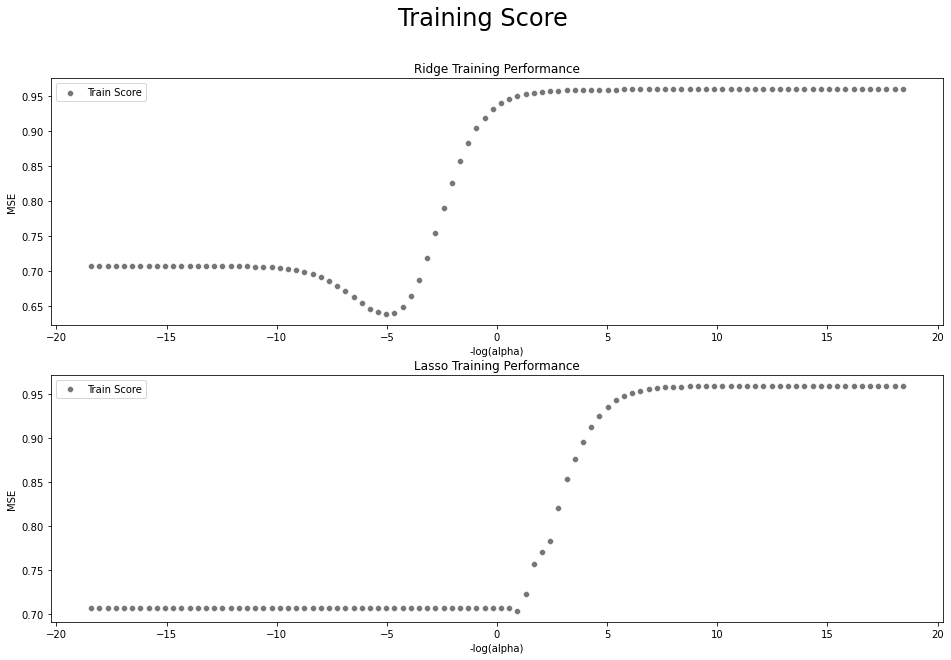

In [10]:
# Creating the dataset for cross validation 
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]


#--------------------------------------------------------------------------------------------------


temp = df.copy()
temp = temp[ind_6]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]
R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]
R_test = temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_train_raw = np.dot(R_train, eq_w)
y_test_raw = np.dot(R_test, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train_raw = np.dot(R_train, N)
X_test_raw = np.dot(R_test, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_train_raw)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_train_raw)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

#-------------------------------------------------------------------------------------------
pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("ridge", Ridge(fit_intercept = False))])

ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                     scoring = 'neg_mean_squared_error')

grid_r.fit(X_train_raw, y_train_raw)

print(f'6 industry: {grid_r.best_params_}')

#--------------------------------------------------------------------------------------------------
pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("lasso", Lasso(fit_intercept = False))])

lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                     scoring = 'neg_mean_squared_error')

grid_l.fit(X_train_raw, y_train_raw)

print(f'6 industry: {grid_l.best_params_}')
print('\n')

#--------------------------------------------------------------------------------------------------

regressions = [Ridge, Lasso]
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
alpha_vec = np.logspace(-8,8,100)
alpha_list = [np.logspace(-8,8,100), np.logspace(-8,8,100)]

counter = 0 

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    cvResults = []
    
    for cur_alpha in alpha_list[counter]:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha, fit_intercept = False))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

        cvResults.append(abs(scores.mean()))
        
    fig = sns.scatterplot(y = cvResults, x = -np.log(alpha_vec), label = "Train Score", ax = axs[counter])
        
    counter += 1

#--------------------------------------------------------------------------------------------------

# Graph
axs[0].title.set_text('Ridge Training Performance')
axs[1].title.set_text('Lasso Training Performance')

axs[0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('Training Score', fontsize = 24)
plt.show()

In [11]:
10**-1

0.1

In [12]:
regressions = [Ridge, Lasso]
alpha_vec = np.logspace(-8,8,100)
alpha_list = np.logspace(-8,8,100)

temp = []


for reg in regressions:
    cvResults = []
    
    for cur_alpha in alpha_list:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha, fit_intercept = False))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

        cvResults.append(abs(scores.mean()))
    
    temp.append(cvResults)



In [13]:
print(-np.log(alpha_vec)[np.argmin(temp[0])])
print(min(temp[0]))

-5.023822021077922
0.6378447527472033


In [14]:
print(-np.log(alpha_vec)[np.argmin(temp[1])])
print(min(temp[1]))

0.9303374113107232
0.7037159425251717


# Q1. Visually showing overfitting 

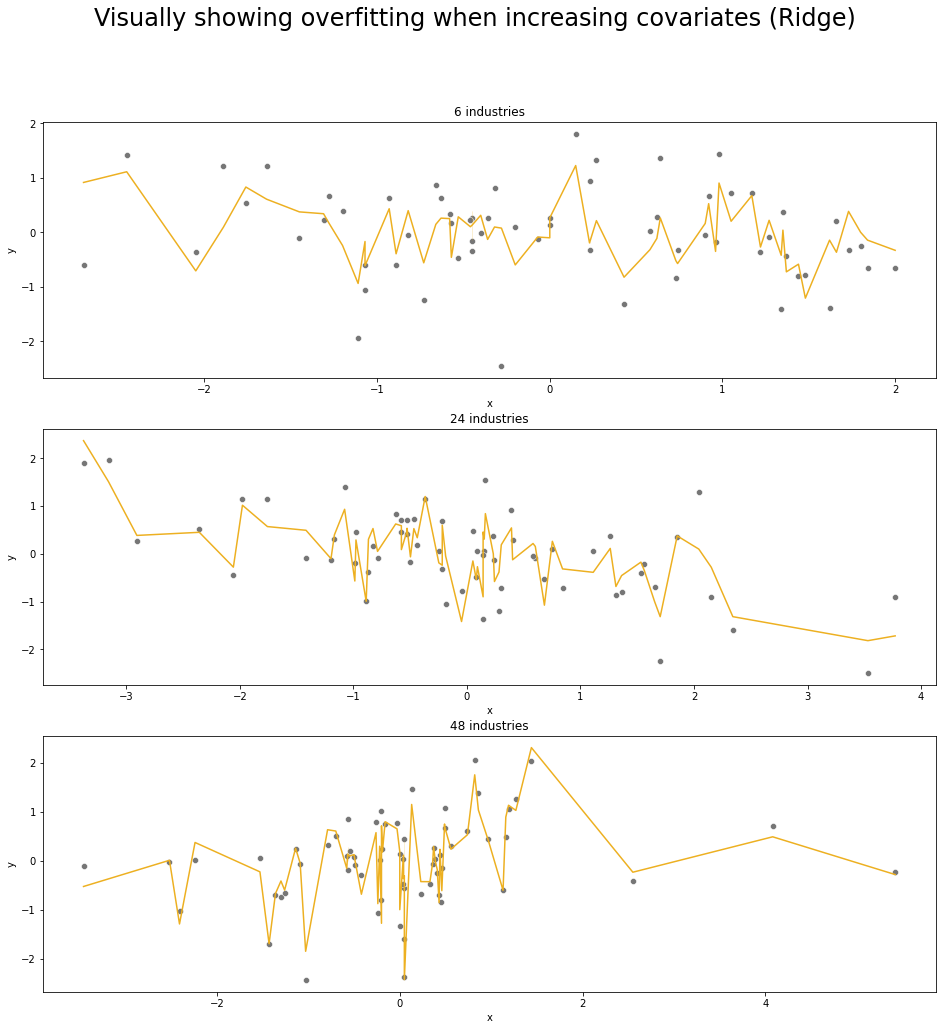

In [15]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

testing = [ind_6, ind_24, ind_48]

fig, axs = plt.subplots(nrows=3, figsize=(16,16))
counter = 0


for cov in testing:
    # This is all code to get the data into dataframe
    # Selecting the columns 
    temp = df.copy()
    temp = temp.loc[:,cov]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = temp.iloc[date_i-63:date_i,:]
    
    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])
    

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = len(cov)
    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_temp = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)
    
    # Calculate X
    X_temp = np.dot(R_train, N)

    #-------------------------------------------------------------------------------------------
    temp_df = pd.DataFrame(X_temp)
    temp_df.columns = ['X' + str(i) for i in temp_df.columns]
    temp_df.insert(1, 'y', y_temp)
    temp_df = temp_df.rename({'X0':'x'}, axis=1)
    
    mdl = Ridge(fit_intercept = False)
    features = temp_df.drop('y', axis = 1)
    target = temp_df['y']
    mdl.fit(features, target)
    preds = mdl.predict(features)
    sns.scatterplot(x = temp_df.x, y = temp_df.y, color='#767676', ax=axs[counter])
    sns.lineplot(x = temp_df.x, y = preds, color='#edb021', ax=axs[counter])
    
    
    counter += 1

#-------------------------------------------------------------------------------------------
axs[0].title.set_text('6 industries')
axs[1].title.set_text('24 industries')
axs[2].title.set_text('48 industries')

plt.suptitle('Visually showing overfitting when increasing covariates (Ridge)', fontsize = 24)

plt.show()

# Q1. Weights of portfolios

In [16]:
ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

#--------------------------------------------------------------------------------------------------
# Find the weights of each of the portfolios
q4_df = df.copy()
q4_df = q4_df[ind_6]

date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

q4_df = q4_df.copy()
q4_df = q4_df.iloc[date_i-no_obj:date_i,:]

R_train = q4_df
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

arr_len = len(ind_6)

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train = np.dot(R_train, N)

#--------------------------------------------------------------------------------------------------
# EW portfolio
print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

#--------------------------------------------------------------------------------------------------

# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_min_var = eq_w - np.dot(N,beta)

print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

#--------------------------------------------------------------------------------------------------

reg = Lasso(ind_6_alphas[0], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_lasso = eq_w - np.dot(N,beta)

print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

#--------------------------------------------------------------------------------------------------

reg = Ridge(ind_6_alphas[1], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_ridge = eq_w - np.dot(N,beta)

print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')

industry_6_p = [eq_w, w_min_var, w_lasso, w_ridge].copy

eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [0.17779, 0.52921, 0.17285, 0.34735, -0.23147, 0.00427]
w_lasso          : [0.16667, 0.2314, 0.16667, 0.16667, 0.16667, 0.10193]
w_ridge          : [0.16888, 0.26772, 0.20019, 0.23074, 0.1198, 0.01267]


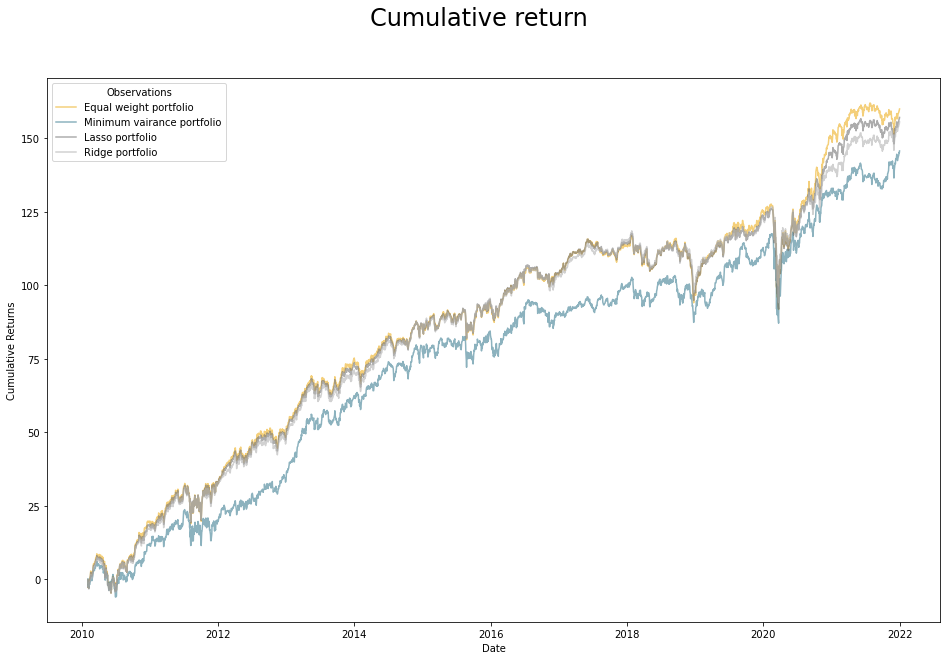

In [17]:
industry_6_p = [eq_w, w_min_var, w_lasso, w_ridge].copy()
plotting = cumulative_returns_calc(df, test, '2022-01-03', 3000, industry_6_p)

plt.figure(figsize=(16,10))
fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3', alpha = .6)



    
fig.legend(title='Observations', labels=['Equal weight portfolio',
                                         'Minimum vairance portfolio',
                                         'Lasso portfolio',
                                         'Ridge portfolio'
                                        ])
fig.set(xlabel='Date', ylabel='Cumulative Returns')


plt.suptitle('Cumulative return', fontsize = 24)
plt.show()

- For this one, you can talk about how the the min var is overfit compared to lasso and ridge as it has no pentaly terms to help to correct its bias 
- Must note that ridge has a VERY LARGE alpha (this can lead to significant underfitting)
- Must note that lasso has a VERY SMALL alpha (this can lead to over fitting, and will behave very close to the OLS regression [min var])

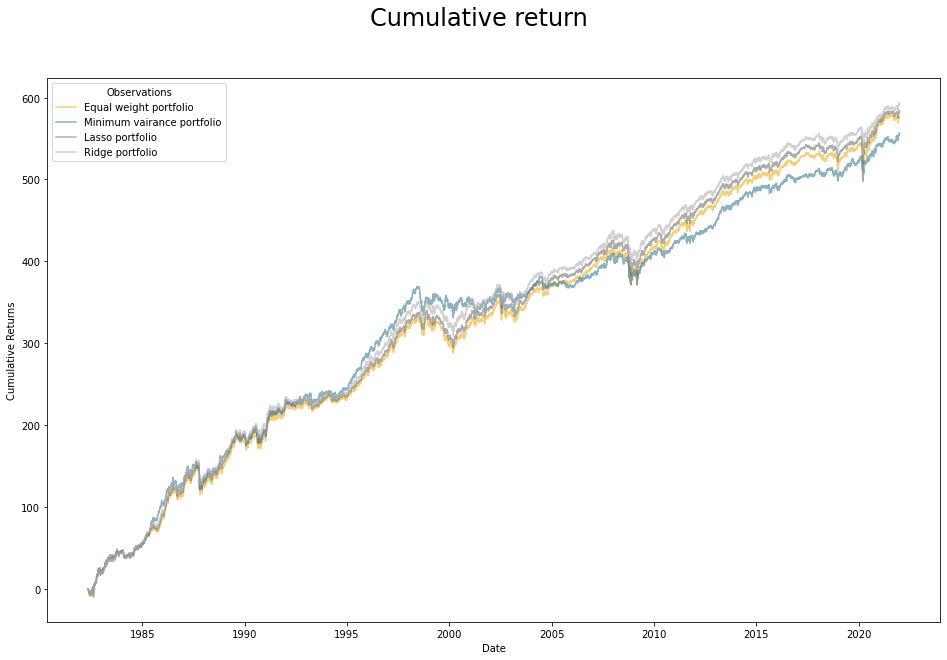

In [18]:
industry_6_p = [eq_w, w_min_var, w_lasso, w_ridge]
plotting = cumulative_returns_calc(df, test, '2022-01-03', 10000, industry_6_p)

plt.figure(figsize=(16,10))
fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676', alpha = .6)
fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3', alpha = .6)



    
fig.legend(title='Observations', labels=['Equal weight portfolio',
                                         'Minimum vairance portfolio',
                                         'Lasso portfolio',
                                         'Ridge portfolio'
                                        ])
fig.set(xlabel='Date', ylabel='Cumulative Returns')


plt.suptitle('Cumulative return', fontsize = 24)
plt.savefig('temp.png')
plt.show()

# Q2. How the values of alpha were chosen 

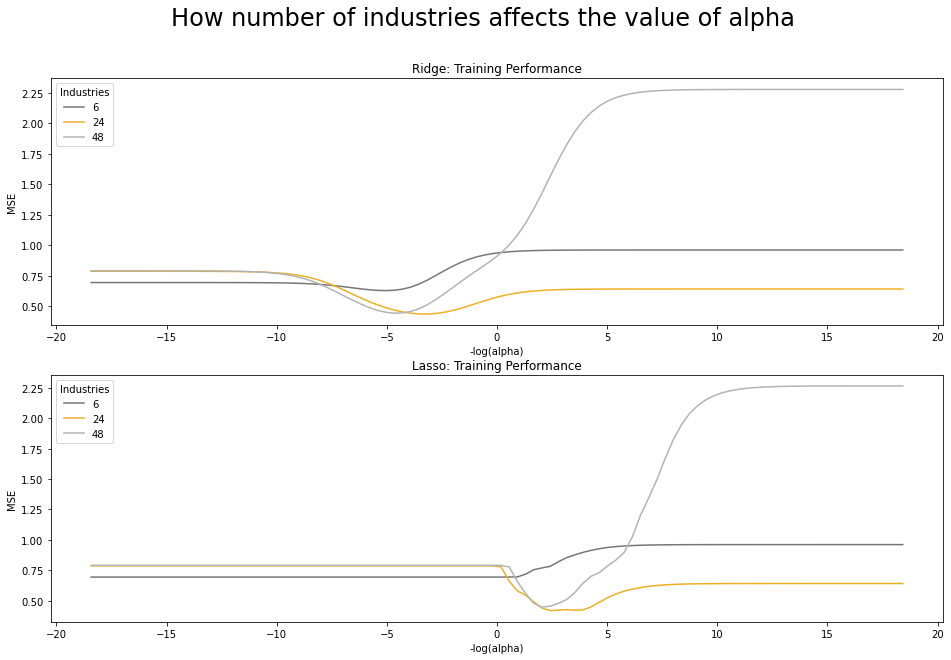

In [19]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

testing = [ind_6, ind_24, ind_48]

#--------------------------------------------------------------------------------------------------

regressions = [Ridge, Lasso]

alpha_vec = list(np.logspace(-8,8,100))
testing = [ind_6, ind_24, ind_48]
colour_palatte = [ '#767676', '#edb021', '#b3b3b3']

fig, axs = plt.subplots(nrows=2, figsize=(16,10))


#--------------------------------------------------------------------------------------------------
row = 0
for reg in regressions:
    colour_picker = 0
    for test in testing:
        cvResults = []
        
        q2_temp = df.copy()
        q2_temp = q2_temp[test]

        # Selecting training set
        date = '2022-01-03'
        no_obj = 63
        date_i = df[df['Date'] == date].index[0]

        R_train = q2_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q2_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])
    
        arr_len = len(test)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)

        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        for cur_alpha in alpha_vec:

            clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                     ("mdl", reg(cur_alpha, fit_intercept = False))])

            # Perform 10-fold cross validation 
            scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                     scoring = 'neg_mean_squared_error', n_jobs = -1)

            cvResults.append(abs(scores.mean()))
        #-----------------------------------------------------------------------------------------------    
        fig = sns.lineplot(x=-np.log(alpha_vec), y=cvResults, ax=axs[row],
                       color = colour_palatte[colour_picker])
        colour_picker += 1
        
    row += 1


#--------------------------------------------------------------------------------------------------
# Graph
axs[0].title.set_text('Ridge: Training Performance')
axs[1].title.set_text('Lasso: Training Performance')

axs[0].legend(title='Industries', labels=['6', '24', '48'])
axs[1].legend(title='Industries', labels=['6', '24', '48'])

axs[0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')


plt.suptitle('How number of industries affects the value of alpha', fontsize = 24)
plt.show()

# Q2. Changing the number of industries 

In [20]:
# 24 INDUSTRY

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]



ind_24_alphas = [lasso_24_alpha, ridge_24_alpha]


#--------------------------------------------------------------------------------------------------
# Find the weights of each of the portfolios
q4_df = df.copy()
q4_df = q4_df[ind_24]

date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

q4_df = q4_df.copy()
q4_df = q4_df.iloc[date_i-no_obj:date_i,:]

R_train = q4_df
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

arr_len = len(ind_24)

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train = np.dot(R_train, N)

#--------------------------------------------------------------------------------------------------
# EW portfolio
print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

#--------------------------------------------------------------------------------------------------

# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_min_var = eq_w - np.dot(N,beta)

print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

#--------------------------------------------------------------------------------------------------

reg = Lasso(ind_24_alphas[0], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_lasso = eq_w - np.dot(N,beta)

print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

#--------------------------------------------------------------------------------------------------

reg = Ridge(ind_24_alphas[1], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_ridge = eq_w - np.dot(N,beta)

print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')


industry_24_p = [eq_w, w_min_var, w_lasso, w_ridge].copy()



eq_w             : [0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167]
w_min_var        : [0.41803, 0.20401, 0.15628, 0.20983, -0.27521, 0.0735, -0.06905, 0.06856, -0.01809, 0.00412, 0.01005, 0.05506, -0.04251, -0.11613, 0.09568, -0.20158, 0.35772, -0.09831, -0.03946, 0.07751, 0.11014, 0.16481, -0.05034, -0.09461]
w_lasso          : [0.24711, 0.04167, 0.04167, 0.04167, -0.16586, 0.04167, 0.04167, 0.04167, 0.04167, 0.03512, 0.04167, 0.04167, 0.04167, 0.00418, 0.04167, 0.04167, 0.29218, 0.04167, 0.04167, 0.04167, 0.04167, 0.04167, -0.01446, -0.10661]
w_ridge          : [0.20911, 0.11732, 0.09316, 0.06925, -0.11299, 0.04509, 0.09732, 0.09856, 0.02055, 0.01556, 0.06155, 0.03098, 0.07634, -0.03347, 0.08868, -0.02986, 0.21877, -0.04677, 0.01403, 0.04526, 0.0746, 0.07741, -0.0438, -0.18667]


In [21]:
# 48 INDUSTRY

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]



ind_48_alphas = [lasso_48_alpha, ridge_48_alpha]


#--------------------------------------------------------------------------------------------------
# Find the weights of each of the portfolios
q4_df = df.copy()
q4_df = q4_df[ind_48]

date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

q4_df = q4_df.copy()
q4_df = q4_df.iloc[date_i-no_obj:date_i,:]

R_train = q4_df
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

arr_len = len(ind_48)

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train = np.dot(R_train, N)

#--------------------------------------------------------------------------------------------------
# EW portfolio
print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

#--------------------------------------------------------------------------------------------------

# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_min_var = eq_w - np.dot(N,beta)

print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

#--------------------------------------------------------------------------------------------------

reg = Lasso(ind_48_alphas[0], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_lasso = eq_w - np.dot(N,beta)

print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

#--------------------------------------------------------------------------------------------------

reg = Ridge(ind_48_alphas[1], fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w_ridge = eq_w - np.dot(N,beta)

print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')


industry_48_p = [eq_w, w_min_var, w_lasso, w_ridge].copy()

eq_w             : [0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083, 0.02083]
w_min_var        : [0.09058, -0.35634, 0.12362, -0.29318, 0.20356, 0.04289, 0.0121, 0.09446, 0.30327, 0.07746, -0.18806, 0.01895, 0.42395, 0.16466, -0.01513, -0.0589, -0.42838, 0.25185, 0.12611, 0.00085, -0.09501, 0.30926, -0.0452, -0.00705, -0.24802, 0.27881, -0.091, -0.01259, -0.02285, 0.17417, 0.26414, -0.04408, -0.0254, -0.46033, 0.21601, -0.00997, 0.33181, -0.19764, 0.104, 0.31834, -0.66661, 0.13376, 0.68856, 0.10299, 0.07461, -0.43582, -0.18392, -0.04529]
w_lasso          : [0.01825, 0.02083, 0.02083, 0.02083, 0.14682, 0.02083, 0.02083,

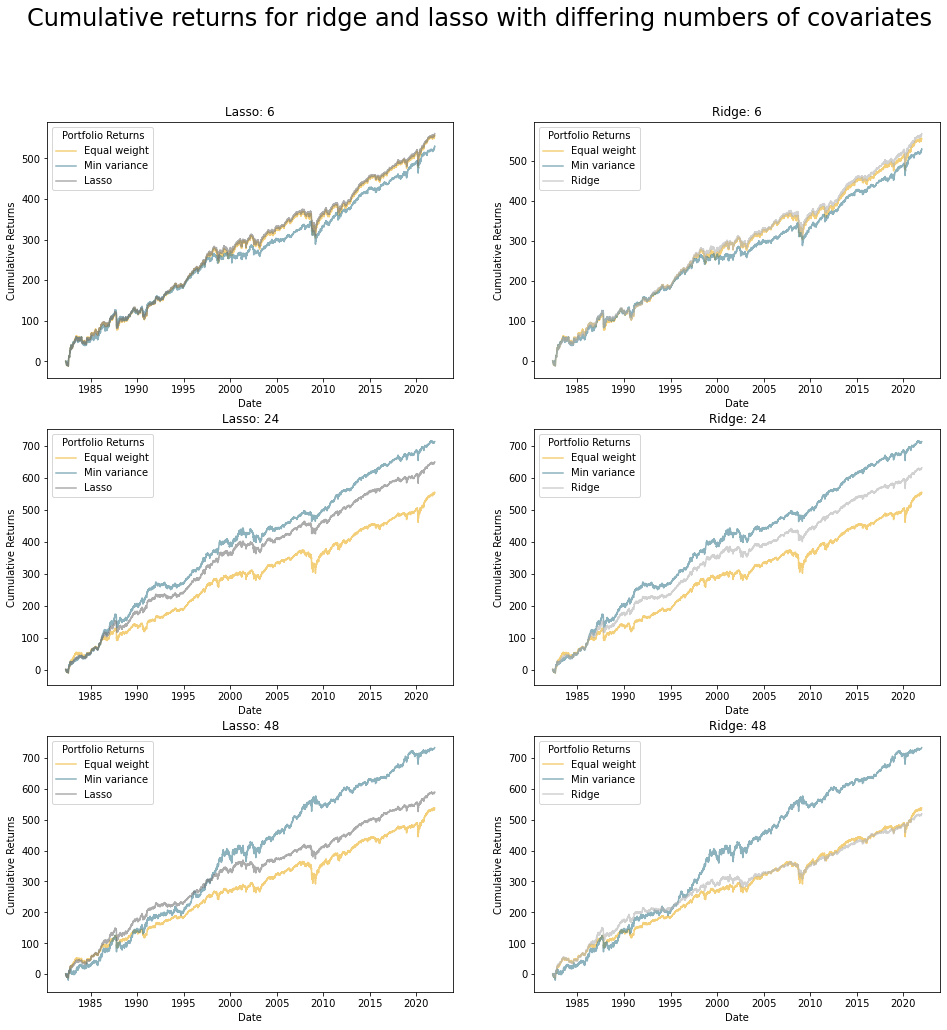

In [22]:
portfolios = [industry_6_p, industry_24_p, industry_48_p]
testing = [ind_6, ind_24, ind_48]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

for i in range(len(portfolios)):
    plotting = cumulative_returns_calc(df, testing[i], '2022-01-03', 10000, portfolios[i])
    
    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])
    
    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

#--------------------------------------------------------------------------------------------------    
    
axs[0,0].title.set_text('Lasso: 6')
axs[1,0].title.set_text('Lasso: 24')
axs[2,0].title.set_text('Lasso: 48')
axs[0,1].title.set_text('Ridge: 6')
axs[1,1].title.set_text('Ridge: 24')
axs[2,1].title.set_text('Ridge: 48')

axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[2,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[2,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with differing numbers of covariates', fontsize = 24)
plt.show()    

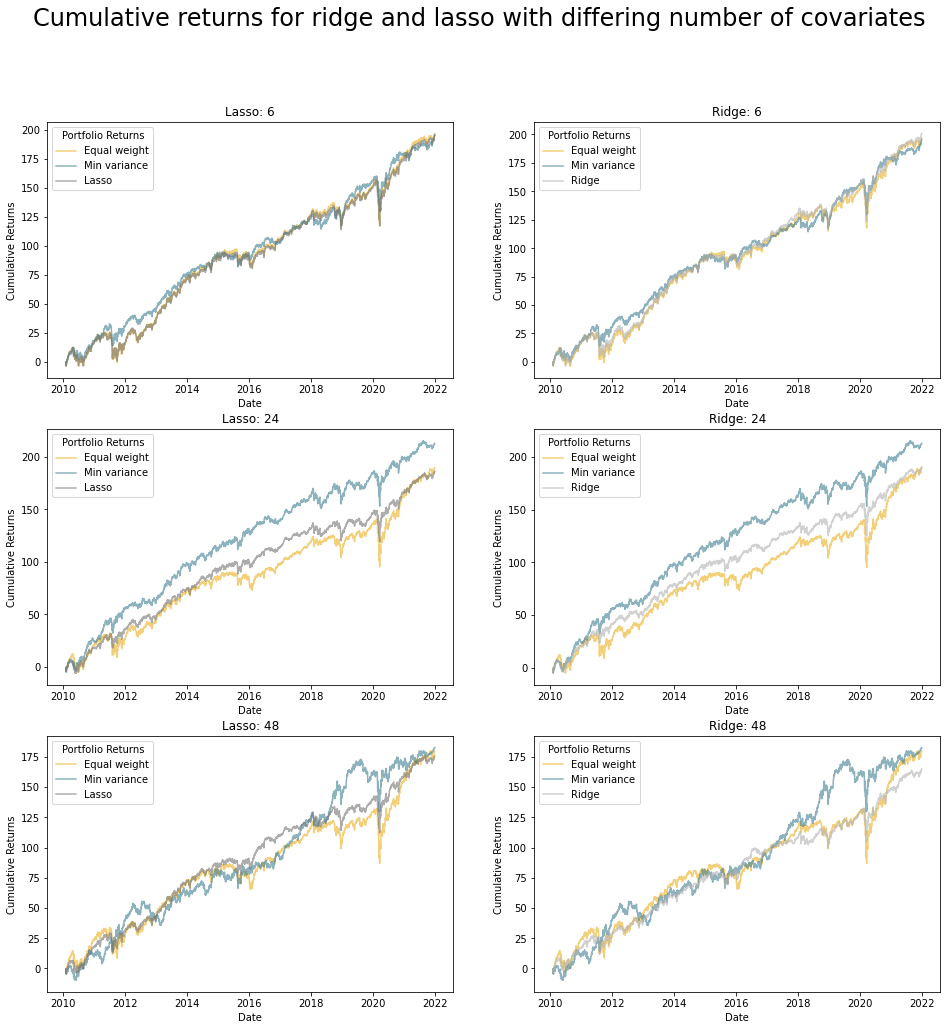

In [23]:
portfolios = [industry_6_p, industry_24_p, industry_48_p]
testing = [ind_6, ind_24, ind_48]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

for i in range(len(portfolios)):
    plotting = cumulative_returns_calc(df, testing[i], '2022-01-03', 3000, portfolios[i])
    
    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])
    
    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

#--------------------------------------------------------------------------------------------------
    
axs[0,0].title.set_text('Lasso: 6')
axs[1,0].title.set_text('Lasso: 24')
axs[2,0].title.set_text('Lasso: 48')
axs[0,1].title.set_text('Ridge: 6')
axs[1,1].title.set_text('Ridge: 24')
axs[2,1].title.set_text('Ridge: 48')

axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[2,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[2,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with differing number of covariates', fontsize = 24)
plt.show()    

# Q3. How the values of alpha were chosen 

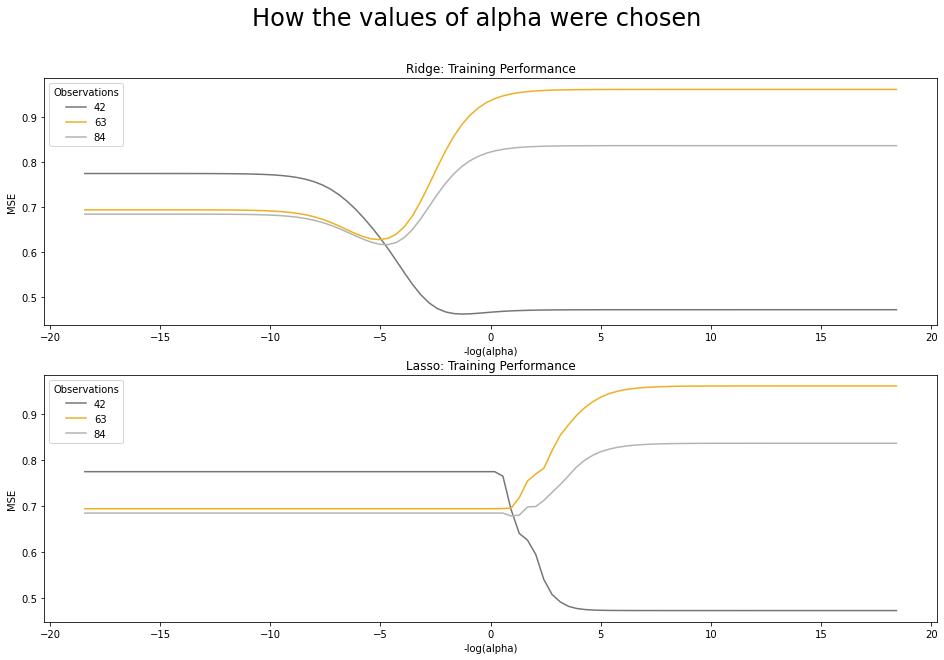

In [24]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

observations = [42, 63, 84]
alpha_list = np.logspace(-8,8,100)
regressions = [Ridge, Lasso]

colour_palatte = [ '#767676', '#edb021', '#b3b3b3']

fig, axs = plt.subplots(nrows=2, figsize=(16,10))
row = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    colour_picker = 0
    for obv in observations:
        cvResults = []
        
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

        arr_len = len(ind_6)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)

        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        
        #--------------------------------------------------------------------------------------------
        # Model fitting
        for cur_alpha in alpha_list:

            clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("mdl", reg(cur_alpha, fit_intercept = False))])
            
            # Perform 10-fold cross validation 
            scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

            cvResults.append(abs(scores.mean()))
            
        #--------------------------------------------------------------------------------------------

        fig = sns.lineplot(x=-np.log(alpha_list), y=cvResults, ax=axs[row],
                           color = colour_palatte[colour_picker])
        colour_picker += 1
        
    row += 1

#--------------------------------------------------------------------------------------------------

axs[0].title.set_text('Ridge: Training Performance')
axs[1].title.set_text('Lasso: Training Performance')

axs[0].legend(title='Observations', labels=['42', '63', '84'])
axs[1].legend(title='Observations', labels=['42', '63', '84'])

axs[0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')


plt.suptitle('How the values of alpha were chosen', fontsize = 24)
plt.show()

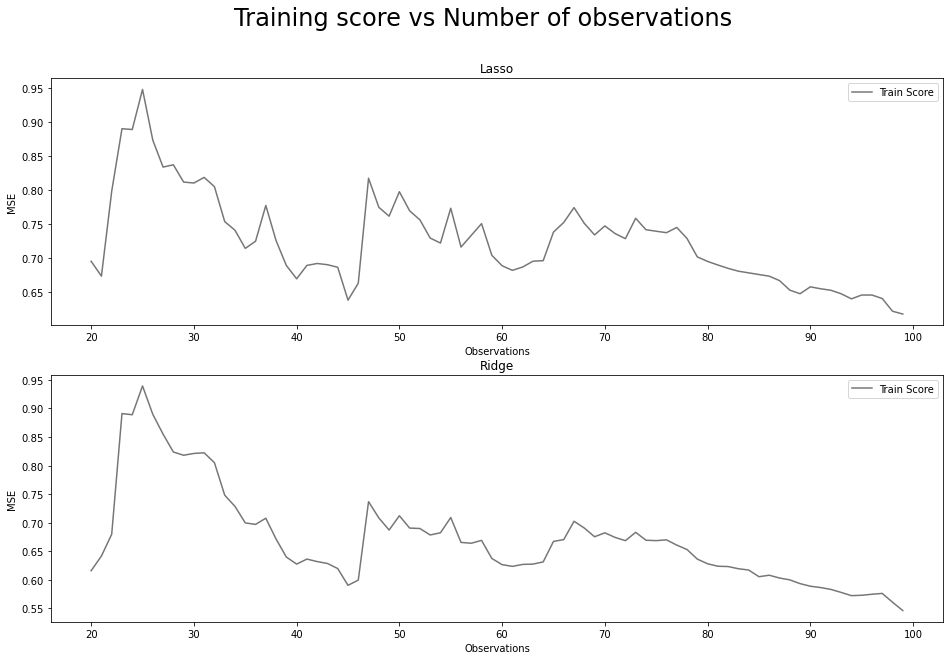

In [25]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Lasso, Ridge]
alpha_list = [lasso_6_alpha, ridge_6_alpha]

observations = list(np.arange(20,100,1))

fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------
counter = 0

for reg in regressions:
    cvResults = []

    for obv in observations:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])

        arr_len = len(ind_6)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(alpha_list[counter], fit_intercept = False))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

        cvResults.append(abs(scores.mean()))
        
    #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = cvResults, x = observations,
                       label = "Train Score", color='#767676', ax = axs[counter])
    
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0].title.set_text('Lasso')
axs[1].title.set_text('Ridge')
axs[0].set(xlabel='Observations', ylabel='MSE')
axs[1].set(xlabel='Observations', ylabel='MSE')


plt.suptitle('Training score vs Number of observations', fontsize = 24)
plt.show()

# Q3. How the number of observations affects results

6 industry: {'ridge__alpha': 3.6783797718286344}
6 industry: {'lasso__alpha': 8.111308307896873e-06}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [-0.21737, 0.31281, 0.66946, 0.2465, -0.00694, -0.00445]
w_lasso          : [-0.21735, 0.3128, 0.66945, 0.24649, -0.00693, -0.00446]
w_ridge          : [-0.11759, 0.31457, 0.5826, 0.26616, -0.0305, -0.01524]


6 industry: {'ridge__alpha': 151.99110829529394}
6 industry: {'lasso__alpha': 0.39442060594376643}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [0.17779, 0.52921, 0.17285, 0.34735, -0.23147, 0.00427]
w_lasso          : [0.16667, 0.2314, 0.16667, 0.16667, 0.16667, 0.10193]
w_ridge          : [0.16888, 0.26772, 0.20019, 0.23074, 0.1198, 0.01267]


6 industry: {'ridge__alpha': 104.76157527896662}
6 industry: {'lasso__alpha': 0.39442060594376643}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [0.21755

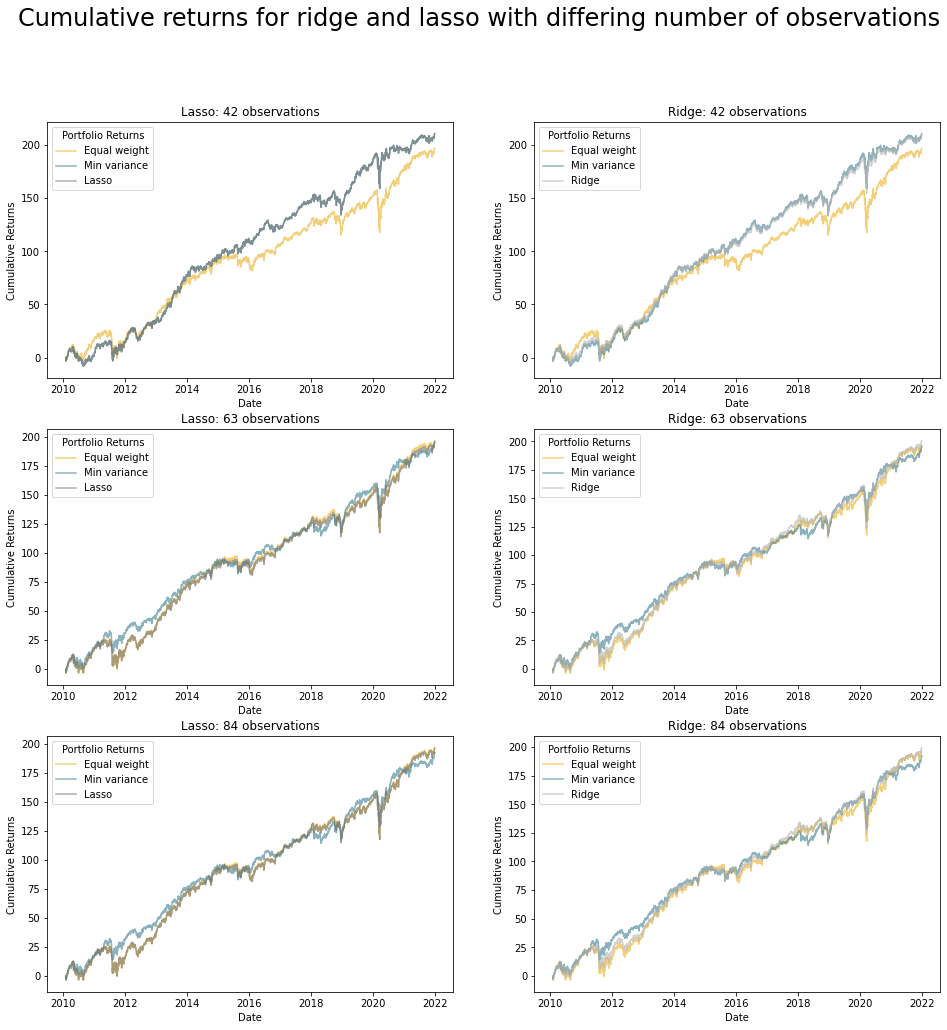

In [34]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

observations = [42, 63, 84]
regressions = [Ridge, Lasso]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

i = 0
for obv in observations:
    arr_len = len(ind_6)

    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]

    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train = np.dot(R_train, N)
    
    #-------------------------------------------------------------------------------------------
    temp = df.copy()
    temp = temp[ind_6]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]
    R_train = temp.iloc[date_i-no_obj:date_i,:]

    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(no_obj / .7 * .3)
    date_i = df[df['Date'] == date].index[0]
    R_test = temp.iloc[date_i:date_i+no_obj,:]

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)
    
    #--------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------
    # Calculate alphas
    # Processing
    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]
    
    arr_len = q3_temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)

    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_r.fit(X_train_raw, y_train_raw)
    
    ridge_6_alpha = grid_r.best_params_['ridge__alpha']
    print(f'6 industry: {grid_r.best_params_}')
    
    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("lasso", Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_l.fit(X_train_raw, y_train_raw)
    
    lasso_6_alpha = grid_l.best_params_['lasso__alpha']
    print(f'6 industry: {grid_l.best_params_}')

    ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
    #--------------------------------------------------------------------------------------------------
    # EW portfolio
    print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

    #--------------------------------------------------------------------------------------------------

    # Linear regression to get min var portfolio
    reg = LinearRegression(fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_min_var = eq_w - np.dot(N,beta)

    print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

    #--------------------------------------------------------------------------------------------------

    reg = Lasso(ind_6_alphas[0], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_lasso = eq_w - np.dot(N,beta)

    print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

    #--------------------------------------------------------------------------------------------------

    reg = Ridge(ind_6_alphas[1], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_ridge = eq_w - np.dot(N,beta)

    print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')
    print('\n')

    #industry_6_p_temp = [eq_w, w_min_var, w_lasso, w_ridge].copy

    plotting = cumulative_returns_calc(df, ind_6, '2022-01-03', 3000,
                                       [eq_w, w_min_var, w_lasso, w_ridge])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

    i += 1


axs[0,0].title.set_text('Lasso: 42 observations')
axs[1,0].title.set_text('Lasso: 63 observations')
axs[2,0].title.set_text('Lasso: 84 observations')
axs[0,1].title.set_text('Ridge: 42 observations')
axs[1,1].title.set_text('Ridge: 63 observations')
axs[2,1].title.set_text('Ridge: 84 observations')

axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[2,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[2,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with differing number of observations', fontsize = 24)
plt.show()   


6 industry: {'ridge__alpha': 3.6783797718286344}
6 industry: {'lasso__alpha': 8.111308307896873e-06}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [-0.21737, 0.31281, 0.66946, 0.2465, -0.00694, -0.00445]
w_lasso          : [-0.21735, 0.3128, 0.66945, 0.24649, -0.00693, -0.00446]
w_ridge          : [-0.11759, 0.31457, 0.5826, 0.26616, -0.0305, -0.01524]


6 industry: {'ridge__alpha': 151.99110829529394}
6 industry: {'lasso__alpha': 0.39442060594376643}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [0.17779, 0.52921, 0.17285, 0.34735, -0.23147, 0.00427]
w_lasso          : [0.16667, 0.2314, 0.16667, 0.16667, 0.16667, 0.10193]
w_ridge          : [0.16888, 0.26772, 0.20019, 0.23074, 0.1198, 0.01267]


6 industry: {'ridge__alpha': 104.76157527896662}
6 industry: {'lasso__alpha': 0.39442060594376643}
eq_w             : [0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667]
w_min_var        : [0.21755

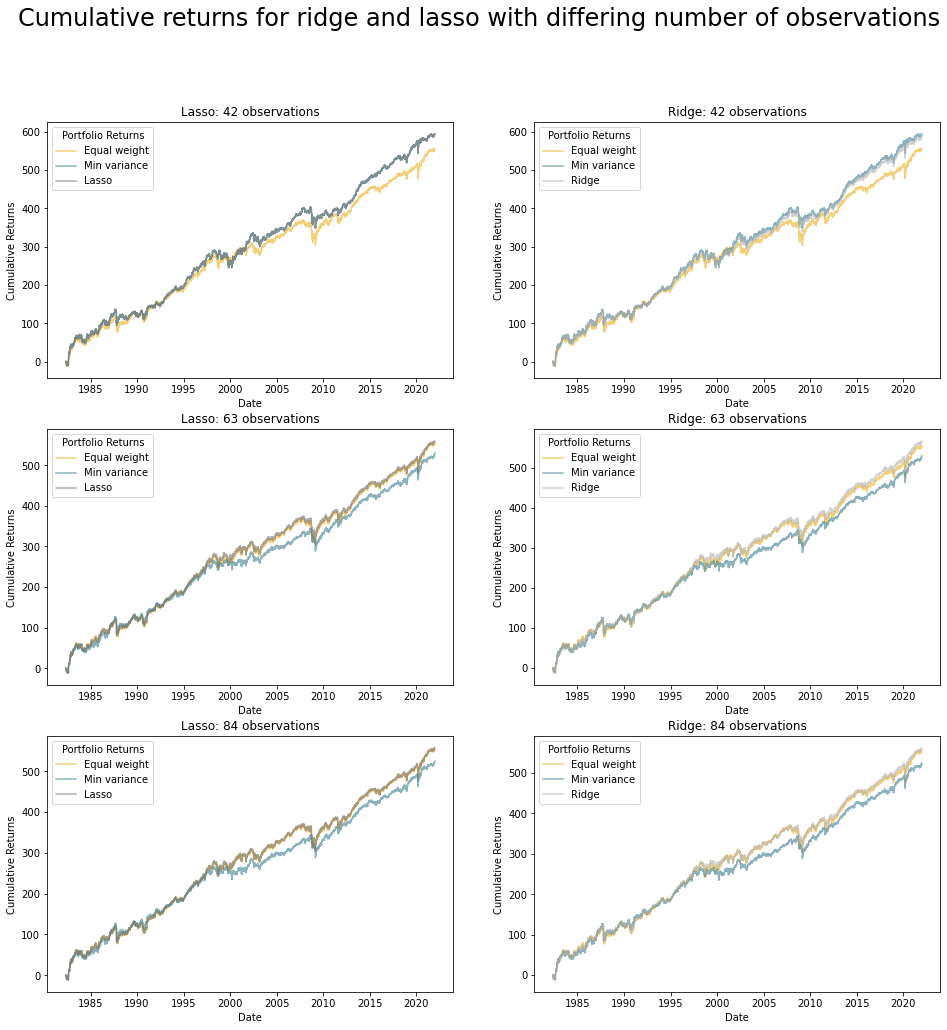

In [33]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

observations = [42, 63, 84]
regressions = [Ridge, Lasso]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

i = 0
for obv in observations:
    arr_len = len(ind_6)

    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]

    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train = np.dot(R_train, N)
    
    #-------------------------------------------------------------------------------------------
    temp = df.copy()
    temp = temp[ind_6]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]
    R_train = temp.iloc[date_i-no_obj:date_i,:]

    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(no_obj / .7 * .3)
    date_i = df[df['Date'] == date].index[0]
    R_test = temp.iloc[date_i:date_i+no_obj,:]

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)
    
    #--------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------
    # Calculate alphas
    # Processing
    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]
    
    arr_len = q3_temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)

    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_r.fit(X_train_raw, y_train_raw)
    
    ridge_6_alpha = grid_r.best_params_['ridge__alpha']
    print(f'6 industry: {grid_r.best_params_}')
    
    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("lasso", Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_l.fit(X_train_raw, y_train_raw)
    
    lasso_6_alpha = grid_l.best_params_['lasso__alpha']
    print(f'6 industry: {grid_l.best_params_}')

    ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
    #--------------------------------------------------------------------------------------------------
    # EW portfolio
    print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

    #--------------------------------------------------------------------------------------------------

    # Linear regression to get min var portfolio
    reg = LinearRegression(fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_min_var = eq_w - np.dot(N,beta)

    print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

    #--------------------------------------------------------------------------------------------------

    reg = Lasso(ind_6_alphas[0], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_lasso = eq_w - np.dot(N,beta)

    print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

    #--------------------------------------------------------------------------------------------------

    reg = Ridge(ind_6_alphas[1], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_ridge = eq_w - np.dot(N,beta)

    print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')
    print('\n')

    #industry_6_p_temp = [eq_w, w_min_var, w_lasso, w_ridge].copy

    plotting = cumulative_returns_calc(df, ind_6, '2022-01-03', 10000,
                                       [eq_w, w_min_var, w_lasso, w_ridge])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

    i += 1


axs[0,0].title.set_text('Lasso: 42 observations')
axs[1,0].title.set_text('Lasso: 63 observations')
axs[2,0].title.set_text('Lasso: 84 observations')
axs[0,1].title.set_text('Ridge: 42 observations')
axs[1,1].title.set_text('Ridge: 63 observations')
axs[2,1].title.set_text('Ridge: 84 observations')

axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[2,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[2,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with differing number of observations', fontsize = 24)
plt.show()   


# Q3. Polynomial features overfitting visualisations

- The primary assumption of Polynomial Regression is that there might exist a non-linear relationship between the features (independent variables) and the target (dependent variable). It is also used when the linear model is unable to capture the trend in the data and gives a poor R² score. In this case, Polynomial Regression increases the model complexity by adding “new” features from existing ones using their higher powers and combinations.


- Polynomial Regression exposes the interactions between the features and target and interactions among the features, if any. Linear models such as Linear Regression and Logistic Regression can be made much more powerful and complex using Polynomial Regression.


- One downside of Polynomial Regression is that it requires a lot of experimenting with its parameters as there is no hard and fast rule associated with it.

In [ ]:
# Data processing for this part 
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

temp = df.copy()
temp = temp.loc[:,ind_6]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = R_train.copy()
R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = R_test.copy()
R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_temp = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_temp = np.dot(R_train, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_temp)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_temp)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

#-------------------------------------------------------------------------------------------

In [ ]:

pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso(alpha_list[1], tol=1e-2, fit_intercept = False))])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge(alpha_list[0], fit_intercept = False))])

#--------------------------------------------------------------------------------------------------

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Lasso, Ridge]
alpha_list = [lasso_6_alpha, ridge_6_alpha]

poly_list = [1,3,10]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

col = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    train_mse = []
    train_r2 = []
    
    test_r2 = []
    test_mse = []
    row = 0
    
    for poly in poly_list:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = 63
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

        arr_len = len(ind_6)
        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        model = Pipeline([("scaler", StandardScaler(with_std = False)),
                          ('poly', PolynomialFeatures(degree = poly, )),
                          ('fit', reg(alpha_list[0]))])
        
        temp_df = pd.DataFrame(X_train_raw)
        temp_df.columns = ['X' + str(i) for i in temp_df.columns]
        temp_df.insert(1, 'y', y_train_raw)
        temp_df = temp_df.rename({'X0':'x'}, axis=1)
        
        features = temp_df.drop('y', axis = 1)
        target = temp_df['y']
        preds = model.fit(features, target).predict(features)
        sns.scatterplot(x = temp_df.x, y = temp_df.y, color='#767676', ax = axs[row,col])
        sns.lineplot(x = temp_df.x, y = preds, color='#edb021', ax = axs[row,col])
        row += 1
        
    col += 1


#--------------------------------------------------------------------------------------------------
# Graph

axs[0,0].title.set_text('Lasso: Poly degree 1')
axs[1,0].title.set_text('Lasso: Poly degree 3')
axs[2,0].title.set_text('Lasso: Poly degree 10')
axs[0,1].title.set_text('Ridge: Poly degree 1')
axs[1,1].title.set_text('Ridge: Poly degree 3')
axs[2,1].title.set_text('Ridge: Poly degree 10')
        
        

In [ ]:
#--------------------------------------------------------------------------------------------------

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

regressions = [Lasso, Ridge]
alpha_list = [lasso_6_alpha, ridge_6_alpha]

poly_list = list(np.arange(1,10,1))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

counter = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    train_mse = []
    train_r2 = []
    
    test_r2 = []
    test_mse = []
    
    for poly in poly_list:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])


        arr_len = len(ind_6)
        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        model = Pipeline([("scaler", StandardScaler(with_std = False)),
                          ('poly', PolynomialFeatures(degree = poly, )),
                          ('fit', reg(alpha_list[0], fit_intercept = False))])
        
        score_mse = cross_val_score(estimator = model , X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)
        train_mse.append(abs(score_mse.mean()))
        
        score_r2 = cross_val_score(estimator = model, X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'r2', n_jobs = -1)
        train_r2.append(abs(score_r2.mean()))
        
    #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = train_mse, x = poly_list, color='#767676', ax = axs[counter,0])
    
    fig = sns.lineplot(y = train_r2, x = poly_list, color='#767676', ax = axs[counter,1])
    
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0,0].title.set_text('Lasso MSE')
axs[1,0].title.set_text('Ridge MSE')
axs[0,1].title.set_text('Lasso R2')
axs[1,1].title.set_text('Ridge R2')
axs[0,0].set(xlabel='Polynomial degree', ylabel='MSE')
axs[0,1].set(xlabel='Polynomial degree', ylabel='R2')
axs[1,0].set(xlabel='Polynomial degree', ylabel='MSE')
axs[1,1].set(xlabel='Polynomial degree', ylabel='R2')


plt.suptitle('Model performance vs Polynomial degree', fontsize = 24)
plt.show()

# Polynomial cumulative returns 

In [ ]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

polynomial = [2,5,7]
regressions = [Ridge, Lasso]
ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

i = 0
for poly in polynomial:
    arr_len = len(ind_6)

    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]

    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train = np.dot(R_train, N)
    
    #--------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------
    # Calculate alphas
    # Processing
    arr_len = q3_temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)

    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline([("scaler", StandardScaler(with_std = False)),
                       ('poly', PolynomialFeatures(degree = poly)),
                       ('ridge', Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_r.fit(X_train_raw, y_train_raw)
    
    ridge_6_alpha = grid_r.best_params_['ridge__alpha']
    print(f'6 industry: {grid_r.best_params_}')
    
    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline([("scaler", StandardScaler(with_std = False)),
                       ('poly', PolynomialFeatures(degree = poly)),
                       ('lasso', Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = 'neg_mean_squared_error')

    grid_l.fit(X_train_raw, y_train_raw)
    
    lasso_6_alpha = grid_l.best_params_['lasso__alpha']
    print(f'6 industry: {grid_l.best_params_}')

    ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
    #--------------------------------------------------------------------------------------------------
    # EW portfolio
    print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

    #--------------------------------------------------------------------------------------------------

    # Linear regression to get min var portfolio
    reg = LinearRegression(fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_min_var = eq_w - np.dot(N,beta)

    print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

    #--------------------------------------------------------------------------------------------------

    reg = Lasso(ind_6_alphas[0], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_lasso = eq_w - np.dot(N,beta)

    print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

    #--------------------------------------------------------------------------------------------------

    reg = Ridge(ind_6_alphas[1], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_ridge = eq_w - np.dot(N,beta)

    print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')
    print('\n')

    #industry_6_p_temp = [eq_w, w_min_var, w_lasso, w_ridge].copy

    plotting = cumulative_returns_calc(df, ind_6, '2022-01-03', 10000,
                                       [eq_w, w_min_var, w_lasso, w_ridge])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

    i += 1


axs[0,0].title.set_text('Lasso: Poly 2')
axs[1,0].title.set_text('Lasso: Poly 5')
axs[2,0].title.set_text('Lasso: Poly 7')
axs[0,1].title.set_text('Ridge: Poly 2')
axs[1,1].title.set_text('Ridge: Poly 5')
axs[2,1].title.set_text('Ridge: Poly 7')

axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[2,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[2,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[2,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with polynomial regression degrees', fontsize = 24)
plt.show()   


# Q3. Sum of absolute deviations alpha 

In [ ]:
regressions = [Lasso, Ridge]
fig, axs = plt.subplots(nrows=2, figsize=(16,10))

alpha_list = np.logspace(-8,8,100)

counter = 0 

#-------------------------------------------------------------------------------------------
# Creating the dataset for cross validation 
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

temp = df.copy()
temp = temp.loc[:,ind_6]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_train_raw = np.dot(R_train, eq_w)
y_test_raw = np.dot(R_test, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train_raw = np.dot(R_train, N)
X_test_raw = np.dot(R_test, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_train_raw)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_train_raw)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------

for reg in regressions:
    cvResults1 = []
    cvResults2 = []
    for cur_alpha in alpha_list:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha, fit_intercept = False))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                                 scoring = 'neg_mean_absolute_error', n_jobs = -1)

        cvResults1.append(abs(scores.mean()))
        
    fig = sns.lineplot(y = cvResults1, x = -np.log(alpha_vec), ax = axs[counter])
    
    #--------------------------------------------------------------------------------------------------
    
    for cur_alpha in alpha_list:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha, fit_intercept = False))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 10, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

        cvResults2.append(abs(scores.mean()))
        
    fig = sns.lineplot(y = cvResults2, x = -np.log(alpha_vec), ax = axs[counter], color= '#edb021')
        
    counter += 1

#--------------------------------------------------------------------------------------------------

# Graph
axs[0].title.set_text('Lasso')
axs[1].title.set_text('Ridge')

axs[0].set(xlabel='-log(alpha)', ylabel='MAE')
axs[1].set(xlabel='-log(alpha)', ylabel='MAE')

axs[0].legend(title='Training score', labels=['MAE', 'MSE'])
axs[1].legend(title='Training score', labels=['MAE', 'MSE'])

plt.suptitle('Comparing the alphas of MAE and MSE', fontsize = 24)
plt.show()

# Q3. Returns of MSE vs sum of absolute deviations

In [ ]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

error_list = ['neg_mean_squared_error', 'neg_mean_absolute_error']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

i = 0
for error in error_list:
    arr_len = len(ind_6)

    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]

    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train = np.dot(R_train, N)
    
    #--------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------
    # Calculate alphas
    # Processing
    arr_len = q3_temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)

    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = error)

    grid_r.fit(X_train_raw, y_train_raw)
    
    ridge_6_alpha = grid_r.best_params_['ridge__alpha']
    print(f'6 industry: {grid_r.best_params_}')
    industry_6_a = grid_r.best_params_['ridge__alpha']

    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("lasso", Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = error)

    grid_l.fit(X_train_raw, y_train_raw)
    
    lasso_6_alpha = grid_l.best_params_['lasso__alpha']
    print(f'6 industry: {grid_l.best_params_}')

    ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
    #--------------------------------------------------------------------------------------------------
    # EW portfolio
    print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

    #--------------------------------------------------------------------------------------------------

    # Linear regression to get min var portfolio
    reg = LinearRegression(fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_min_var = eq_w - np.dot(N,beta)

    print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

    #--------------------------------------------------------------------------------------------------

    reg = Lasso(ind_6_alphas[0], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_lasso = eq_w - np.dot(N,beta)

    print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

    #--------------------------------------------------------------------------------------------------

    reg = Ridge(ind_6_alphas[1], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_ridge = eq_w - np.dot(N,beta)

    print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')
    print('\n')


    plotting = cumulative_returns_calc(df, ind_6, '2022-01-03', 3000,
                                       [eq_w, w_min_var, w_lasso, w_ridge])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

    i += 1


axs[0,0].title.set_text('Lasso: MSE')
axs[1,0].title.set_text('Lasso: MAE')
axs[0,1].title.set_text('Ridge: MSE')
axs[1,1].title.set_text('Ridge: MAE')


axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with scoring methods', fontsize = 24)
plt.show()

In [ ]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

error_list = ['neg_mean_squared_error', 'neg_mean_absolute_error']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

#--------------------------------------------------------------------------------------------------

i = 0
for error in error_list:
    arr_len = len(ind_6)

    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]

    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train = np.dot(R_train, N)
    
    #--------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------
    # Calculate alphas
    # Processing
    arr_len = q3_temp.shape[1]

    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_train_raw = np.dot(R_train, eq_w)
    y_test_raw = np.dot(R_test, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    # Calculate X
    X_train_raw = np.dot(R_train, N)
    X_test_raw = np.dot(R_test, N)

    temp_df_raw = pd.DataFrame(X_train_raw)
    temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
    temp_df_raw.insert(1, 'y', y_train_raw)
    temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

    #-------------------------------------------------------------------------------------------
    pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(fit_intercept = False))])

    ridge_params = {'ridge__alpha':np.logspace(-8,8,100)}

    grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 10,
                         scoring = error)

    grid_r.fit(X_train_raw, y_train_raw)
    
    ridge_6_alpha = grid_r.best_params_['ridge__alpha']
    print(f'6 industry: {grid_r.best_params_}')
    industry_6_a = grid_r.best_params_['ridge__alpha']

    #--------------------------------------------------------------------------------------------------
    pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("lasso", Lasso(fit_intercept = False))])

    lasso_params = {'lasso__alpha':np.logspace(-8,8,100)}

    grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 10,
                         scoring = error)

    grid_l.fit(X_train_raw, y_train_raw)
    
    lasso_6_alpha = grid_l.best_params_['lasso__alpha']
    print(f'6 industry: {grid_l.best_params_}')

    ind_6_alphas = [lasso_6_alpha, ridge_6_alpha]
    #--------------------------------------------------------------------------------------------------
    # EW portfolio
    print(f'eq_w             : {[round(num, 5) for num in eq_w]}')

    #--------------------------------------------------------------------------------------------------

    # Linear regression to get min var portfolio
    reg = LinearRegression(fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_min_var = eq_w - np.dot(N,beta)

    print(f'w_min_var        : {[round(num, 5) for num in w_min_var]}')

    #--------------------------------------------------------------------------------------------------

    reg = Lasso(ind_6_alphas[0], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_lasso = eq_w - np.dot(N,beta)

    print(f'w_lasso          : {[round(num, 5) for num in w_lasso]}')

    #--------------------------------------------------------------------------------------------------

    reg = Ridge(ind_6_alphas[1], fit_intercept = False)
    reg.fit(X_train, y_train)

    train_r2 = reg.score(X_train, y_train)
    train_mse = mean_squared_error(y_train, reg.predict(X_train))

    beta = reg.coef_
    w_ridge = eq_w - np.dot(N,beta)

    print(f'w_ridge          : {[round(num, 5) for num in w_ridge]}')
    print('\n')


    plotting = cumulative_returns_calc(df, ind_6, '2022-01-03', 10000,
                                       [eq_w, w_min_var, w_lasso, w_ridge])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,0])
    fig = sns.lineplot(data=plotting, x='Date', y='w_lasso return', color='#767676',
                       alpha = .6, ax = axs[i,0])

    fig = sns.lineplot(data=plotting, x='Date', y='eq_w return', color='#edb021',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_min_var return', color='#3f7f93',
                       alpha = .6, ax = axs[i,1])
    fig = sns.lineplot(data=plotting, x='Date', y='w_ridge return', color='#b3b3b3',
                       alpha = .6, ax = axs[i,1])

    i += 1


axs[0,0].title.set_text('Lasso: MSE')
axs[1,0].title.set_text('Lasso: MAE')
axs[0,1].title.set_text('Ridge: MSE')
axs[1,1].title.set_text('Ridge: MAE')


axs[0,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[1,0].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Lasso'])
axs[0,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])
axs[1,1].legend(title='Portfolio Returns', labels=['Equal weight', 'Min variance', 'Ridge'])


axs[0,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,0].set(xlabel='Date', ylabel='Cumulative Returns')
axs[0,1].set(xlabel='Date', ylabel='Cumulative Returns')
axs[1,1].set(xlabel='Date', ylabel='Cumulative Returns')
    



plt.suptitle('Cumulative returns for ridge and lasso with scoring methods', fontsize = 24)
plt.savefig('temp.png')
plt.show()

# How the number of folds affects results

In [ ]:
# Creating the dataset for cross validation 
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']

temp = df.copy()
temp = temp.loc[:,ind_6]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_train_raw = np.dot(R_train, eq_w)
y_test_raw = np.dot(R_test, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train_raw = np.dot(R_train, N)
X_test_raw = np.dot(R_test, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_train_raw)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_train_raw)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------

regressions = [Ridge, Lasso]
fig, axs = plt.subplots(nrows=2, figsize=(16,10))

alpha_list = [np.logspace(-8,8,100), np.logspace(-8,8,100)]
cv_list = [2,5,8,10,15]

colour_palatte = ['#edb021', '#3f7f93', '#767676', '#b3b3b3', '#212121']

#--------------------------------------------------------------------------------------------------
counter = 0 

for reg in regressions:
    figure = 0
    for folds in cv_list:
        cvResults = []
        
        for cur_alpha in alpha_list[counter]:

            clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                     ("mdl", reg(cur_alpha, fit_intercept = False))])

            # Perform 10-fold cross validation 
            scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = folds, \
                                     scoring = 'neg_mean_squared_error', n_jobs = -1)

            cvResults.append(abs(scores.mean()))

        fig = sns.lineplot(y = cvResults, x = -np.log(alpha_vec), ax = axs[counter],
                           color = colour_palatte[figure])
        figure += 1

    counter += 1

#--------------------------------------------------------------------------------------------------
# Graph

axs[0].title.set_text('Ridge Training Performance')
axs[1].title.set_text('Lasso Training Performance')

axs[0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

axs[0].legend(title='K-Folds', labels=['2', '5', '8', '10', '15'])
axs[1].legend(title='K-Folds', labels=['2', '5', '8', '10', '15'])


plt.suptitle('Training Score', fontsize = 24)
plt.show()